In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import tensorflow as tf
# from keras import backend as K
import keras.backend.tensorflow_backend as K
K.set_session

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras import backend as keras

Using Theano backend.


In [2]:
keras.backend()

'theano'

In [3]:
os.getcwd()
TRAIN_PATH = "data/stage1_train/"
train_ids = next(os.walk(TRAIN_PATH))[1]
# test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

## Train data loader function

In [5]:

def load_train_data(number_of_img=None):
    X_train_ = np.zeros((number_of_img or len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train_ = np.zeros((number_of_img or len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    sys.stdout.flush()
    if number_of_img:
        enumerate_coll = enumerate(train_ids)
    else:
        print('Getting and resizing train images and masks ... ')
        enumerate_coll = tqdm(enumerate(train_ids), total=len(train_ids))
    for n, id_ in enumerate_coll:
        if number_of_img and number_of_img == n:
            break
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train_[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                          preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train_[n] = mask
    return X_train_, Y_train_


In [6]:
X_train, Y_train = load_train_data(2000)

### Plot Data

In [7]:
def plot_original_data(number_of_img=7):
    if number_of_img ==1:
        f, axarr = plt.subplots(number_of_img,2,figsize=(15,6))
        axarr[0].imshow(X_train[0])
        axarr[1].imshow(np.squeeze(Y_train[0]))
    else:
        f, axarr = plt.subplots(2,number_of_img,figsize=(15,6))
        for i in range(0,number_of_img):   
            axarr[0,i].imshow(X_train[i])
            axarr[1,i].imshow(np.squeeze(Y_train[i]))

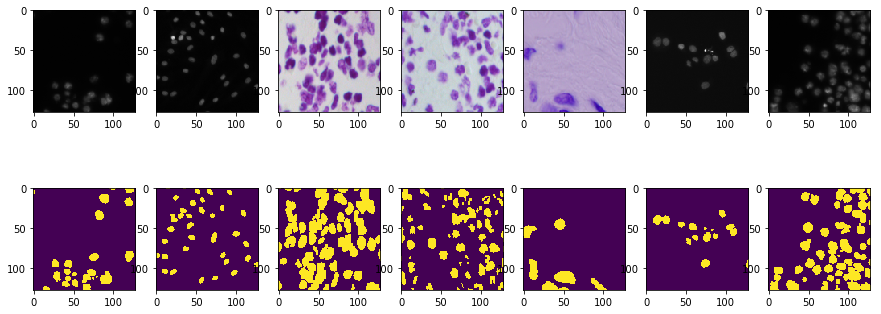

In [8]:
plot_original_data()

## Thresholding Method

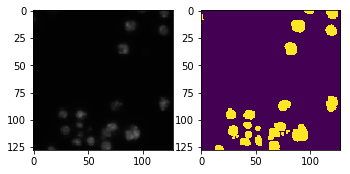

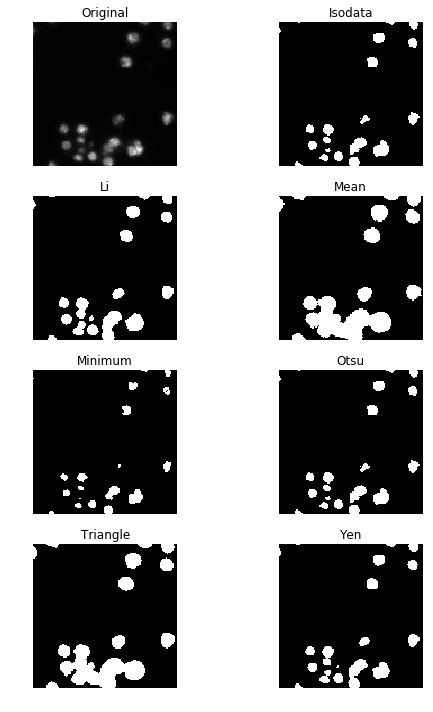

In [13]:
from skimage.filters import try_all_threshold

def thresholding_method():
    f, axarr = plt.subplots(1,2,figsize=(5.5,5))
    axarr[0].imshow(X_train[0])
    axarr[1].imshow(np.squeeze(Y_train[0]))

    fig, ax = try_all_threshold(X_train[0][:, :, 0], figsize=(8, 10), verbose=False)
    plt.show()

thresholding_method()


### Threshold Yen

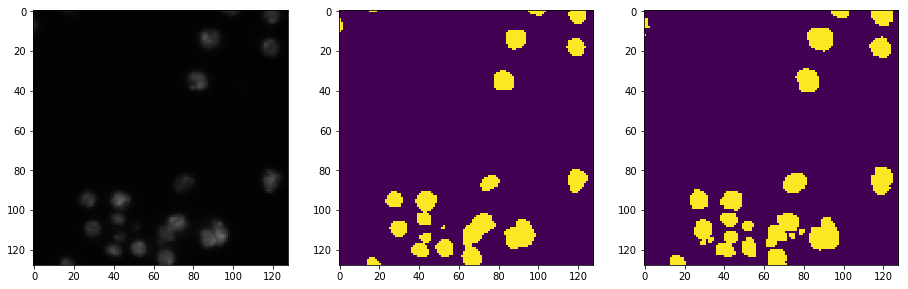

In [14]:
from skimage.filters import threshold_yen

def plot_threshold_yen(i=0):
    image = X_train[i][:, :, 0]
    thresh = threshold_yen(image)
    binary = np.array( image > thresh, dtype=int)
    f, axarr = plt.subplots(1,3,figsize=(15.5,10))
    axarr[0].imshow(X_train[i])
    axarr[1].imshow(binary)
    axarr[2].imshow(np.squeeze(Y_train[i]))

plot_threshold_yen()

In [39]:
def simple_iou(component1,component2):
    overlap = component1*component2 # Logical AND
    union = component1 + component2 # Logical OR
    IOU = overlap.sum()/float(union.sum())
    return IOU

In [19]:
image = X_train[0][:, :, 0]
thresh = threshold_yen(image)
binary = np.array( image > thresh, dtype=int)
simple_iou(binary,np.squeeze(Y_train[0]))

0.42348877374784111

In [20]:
iou_sum = 0
len1 = 0
for i in range(0,20):
    image = X_train[i][:, :, 0]
    thresh = threshold_yen(image)
    binary = np.array( image > thresh, dtype=int)
    iou_sum += simple_iou(binary,np.squeeze(Y_train[i]))
    len1 += 1
print(iou_sum/ len1, len1)

0.384005870748 20


# KERAS Models

### models names:

In [9]:
FCN_model_name = 'FCN-v1.h5'
Unet_model_name = 'U-net-v1.h5'
large_Unet_model_name = 'large-U-net-v1.h5'

## FCN

In [11]:
def train_keras_model(model, model_name, epochs_=30):
    earlystopper = EarlyStopping(patience=5, verbose=1)
    checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    results = model.fit(X_train, Y_train, 
                        validation_split=0.1, 
                        batch_size=8, 
                        epochs=epochs_, 
                        verbose=0,
                        callbacks=[earlystopper, checkpointer])
    return results

In [8]:
def FCN_v1(input_size = (128,128,3)):
    inputs = Input(input_size)
    conv = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    drop = Dropout(0.25)(conv)
    conv = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop)
    conv = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = Conv2D(1, 1, activation = 'sigmoid')(conv)
    model = Model(input = inputs, output = conv)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model 

In [9]:
FCN_v1().summary()

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_1, outputs=sigmoid.0)`
  if __name__ == '__main__':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       224       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 8)       584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 4)       292       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 2)       74        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 1)       3         
Total para

In [14]:
model = FCN_v1()
train_keras_model(model, FCN_model_name)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_5, outputs=sigmoid.0)`
  if __name__ == '__main__':


Epoch 00000: val_loss improved from inf to 0.66855, saving model to FCN-v1.h5
Epoch 00001: val_loss improved from 0.66855 to 0.63133, saving model to FCN-v1.h5
Epoch 00002: val_loss improved from 0.63133 to 0.27797, saving model to FCN-v1.h5
Epoch 00003: val_loss improved from 0.27797 to 0.04354, saving model to FCN-v1.h5
Epoch 00004: val_loss improved from 0.04354 to 0.01509, saving model to FCN-v1.h5
Epoch 00005: val_loss improved from 0.01509 to 0.00788, saving model to FCN-v1.h5
Epoch 00006: val_loss improved from 0.00788 to 0.00506, saving model to FCN-v1.h5
Epoch 00007: val_loss improved from 0.00506 to 0.00370, saving model to FCN-v1.h5
Epoch 00008: val_loss improved from 0.00370 to 0.00267, saving model to FCN-v1.h5
Epoch 00009: val_loss improved from 0.00267 to 0.00154, saving model to FCN-v1.h5
Epoch 00010: val_loss improved from 0.00154 to 0.00099, saving model to FCN-v1.h5
Epoch 00011: val_loss improved from 0.00099 to 0.00068, saving model to FCN-v1.h5
Epoch 00012: val_los

## U-net

In [15]:

def Contracting(inputs, dim):
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    return pool , conv

def Expansive(inputs, parallel_conv, dim):
    up = Conv2D(dim, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(inputs))
    merge_l = merge([parallel_conv,up], mode = 'concat', concat_axis = 3)
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_l)
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    return conv

def Conv_n_Dropout(inputs, dim):
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv = Conv2D(dim, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    drop = Dropout(0.5)(conv)
    return drop
    

In [16]:
def unet(input_size = (128,128,3)):
    """
    this is an my implementation for U-net with keras
    the original imput shape was 256x256x1 -> 64 ->128 ->512 -> 1024, 
    i used 128x128x3 -> 4 ->8 -> 16 ->32 in order to test it on my own cpu 
    i also excluded one pooling group 
    """
    inputs = Input(input_size)
    
    contract4, conv4 = Contracting(inputs, 4)
    contract8, conv8 = Contracting(contract4, 8)
    contract16, conv16 = Contracting(contract8, 16)
    convolve_n_drop32 = Conv_n_Dropout(contract16, 32)
    expan16 = Expansive(convolve_n_drop32, conv16, 16)
    expan8 = Expansive(expan16, conv8, 8)
    expan4 = Expansive(expan8, conv4, 4)
    
    conv2 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(expan4)
    conv1 = Conv2D(1, 1, activation = 'sigmoid')(conv2)

    model = Model(input = inputs, output = conv1)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [17]:
unet().summary()

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Sharon\Anaconda3\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_6, outputs=sigmoid.0)`


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_26 (Conv2D)               (None, 128, 128, 4)   112         input_6[0][0]                    
____________________________________________________________________________________________________
conv2d_27 (Conv2D)               (None, 128, 128, 4)   148         conv2d_26[0][0]                  
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 64, 64, 4)     0           conv2d_27[0][0]                  
___________________________________________________________________________________________

In [18]:
model = unet()
train_model(model, Unet_model_name)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Sharon\Anaconda3\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_7, outputs=sigmoid.0)`


Epoch 00000: val_loss improved from inf to 0.67883, saving model to U-net-v1.h5
Epoch 00001: val_loss improved from 0.67883 to 0.05370, saving model to U-net-v1.h5
Epoch 00002: val_loss improved from 0.05370 to 0.00682, saving model to U-net-v1.h5
Epoch 00003: val_loss improved from 0.00682 to 0.00094, saving model to U-net-v1.h5
Epoch 00004: val_loss improved from 0.00094 to 0.00055, saving model to U-net-v1.h5
Epoch 00005: val_loss improved from 0.00055 to 0.00034, saving model to U-net-v1.h5
Epoch 00006: val_loss improved from 0.00034 to 0.00024, saving model to U-net-v1.h5
Epoch 00007: val_loss improved from 0.00024 to 0.00019, saving model to U-net-v1.h5
Epoch 00008: val_loss improved from 0.00019 to 0.00017, saving model to U-net-v1.h5
Epoch 00009: val_loss improved from 0.00017 to 0.00015, saving model to U-net-v1.h5
Epoch 00010: val_loss improved from 0.00015 to 0.00014, saving model to U-net-v1.h5
Epoch 00011: val_loss improved from 0.00014 to 0.00012, saving model to U-net-v1

In [19]:
def large_unet(input_size = (128,128,3)):
    """
    this is an my implementation for U-net with keras
    the original imput shape was 256x256x1 -> 64 ->128 ->512 -> 1024, 
    i used 128x128x3 -> 4 ->8 -> 16 ->32 -> 64 in order to test it on my own cpu 
    """
    inputs = Input(input_size)
    
    contract4, conv4 = Contracting(inputs, 4)
    contract8, conv8 = Contracting(contract4, 8)
    contract16, conv16 = Contracting(contract8, 16)
    contract32, conv32 = Contracting(contract16, 32)
    convolve_n_drop64 = Conv_n_Dropout(contract32, 64)
    expan32 = Expansive(convolve_n_drop64, conv32, 32)
    expan16 = Expansive(expan32, conv16, 16)
    expan8 = Expansive(expan16, conv8, 8)
    expan4 = Expansive(expan8, conv4, 4)
    
    conv2 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(expan4)
    conv1 = Conv2D(1, 1, activation = 'sigmoid')(conv2)

    model = Model(input = inputs, output = conv1)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [22]:
large_unet().summary()

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Sharon\Anaconda3\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_10, outputs=sigmoid.0)`


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_10 (InputLayer)            (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_112 (Conv2D)              (None, 128, 128, 4)   112         input_10[0][0]                   
____________________________________________________________________________________________________
conv2d_113 (Conv2D)              (None, 128, 128, 4)   148         conv2d_112[0][0]                 
____________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D)  (None, 64, 64, 4)     0           conv2d_113[0][0]                 
___________________________________________________________________________________________

In [23]:
model = large_unet()
train_model(model, large_Unet_model_name)

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Sharon\Anaconda3\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_11, outputs=sigmoid.0)`


Epoch 00000: val_loss improved from inf to 0.64736, saving model to large-U-net-v1.h5
Epoch 00001: val_loss improved from 0.64736 to 0.00855, saving model to large-U-net-v1.h5
Epoch 00002: val_loss improved from 0.00855 to 0.00557, saving model to large-U-net-v1.h5
Epoch 00003: val_loss improved from 0.00557 to 0.00036, saving model to large-U-net-v1.h5
Epoch 00004: val_loss improved from 0.00036 to 0.00028, saving model to large-U-net-v1.h5
Epoch 00005: val_loss improved from 0.00028 to 0.00021, saving model to large-U-net-v1.h5
Epoch 00006: val_loss improved from 0.00021 to 0.00020, saving model to large-U-net-v1.h5
Epoch 00007: val_loss improved from 0.00020 to 0.00009, saving model to large-U-net-v1.h5
Epoch 00008: val_loss improved from 0.00009 to 0.00005, saving model to large-U-net-v1.h5
Epoch 00009: val_loss improved from 0.00005 to 0.00004, saving model to large-U-net-v1.h5
Epoch 00010: val_loss improved from 0.00004 to 0.00004, saving model to large-U-net-v1.h5
Epoch 00011: v

RuntimeError: CorrMM failed to allocate working memory of 1 x 72 x 16384

Apply node that caused the error: CorrMM_gradInputs{half, (1, 1), (1, 1)}(Subtensor{::, ::, ::int64, ::int64}.0, InplaceDimShuffle{0,3,1,2}.0, Subtensor{int64}.0, Subtensor{int64}.0)
Toposort index: 517
Inputs types: [TensorType(float32, 4D), TensorType(float32, 4D), TensorType(int64, scalar), TensorType(int64, scalar)]
Inputs shapes: [(4, 8, 3, 3), (8, 4, 128, 128), (), ()]
Inputs strides: [(4, 16, -384, -128), (262144, 65536, 512, 4), (), ()]
Inputs values: ['not shown', 'not shown', array(128, dtype=int64), array(128, dtype=int64)]
Outputs clients: [[InplaceDimShuffle{0,2,3,1}(CorrMM_gradInputs{half, (1, 1), (1, 1)}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\theano\gradient.py", line 1272, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\theano\gradient.py", line 967, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\theano\gradient.py", line 967, in <listcomp>
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\theano\gradient.py", line 1272, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\theano\gradient.py", line 967, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\theano\gradient.py", line 967, in <listcomp>
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\theano\gradient.py", line 1272, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "C:\Users\Sharon\Anaconda3\lib\site-packages\theano\gradient.py", line 1108, in access_term_cache
    new_output_grads)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

## Predict on FCN

In [32]:
model = load_model(FCN_model_name)
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

200/200 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s     


### check for some resonable TH, TODO: find best TH

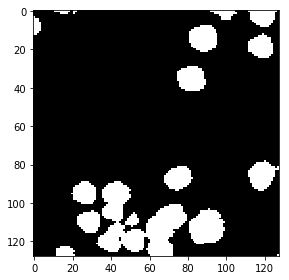

In [33]:
imshow(np.squeeze(preds_train[0]> 0.2))

In [35]:
preds_train_t = (preds_train > 0.2).astype(np.uint8)

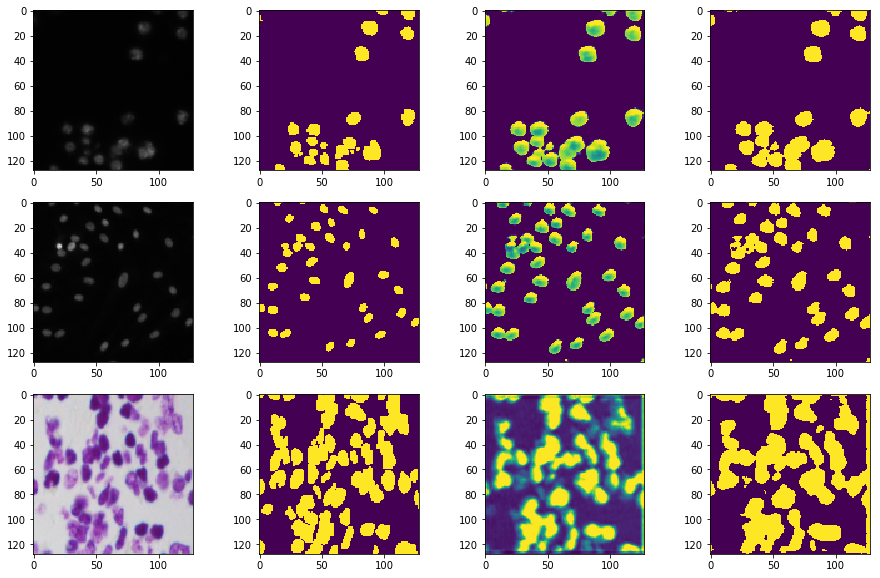

In [36]:
f, axarr = plt.subplots(3,4,figsize=(15.5,10))
for i in range(0,3):
    axarr[i,0].imshow(X_train[i])
    axarr[i,1].imshow(np.squeeze(Y_train[i]))
    axarr[i,2].imshow(np.squeeze(preds_train[i]))
    axarr[i,3].imshow(np.squeeze(preds_train_t[i]))

In [40]:
simple_iou(np.squeeze(preds_train_t[0]),np.squeeze(Y_train[0]))

0.39487434685245087

In [41]:
iou_sum = 0
len1 = 0
for i in range(0,20):
    iou_sum += simple_iou(np.squeeze(preds_train_t[i]),np.squeeze(Y_train[i]))
    len1 += 1
print(iou_sum/ len1, len1)

0.340404479758 20


## Predict on Unet

In [42]:
model = load_model(Unet_model_name)
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

C:\Users\Sharon\Anaconda3\lib\site-packages\keras\engine\topology.py:1242: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


200/200 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s     


### check for some resonable TH, TODO: find best TH

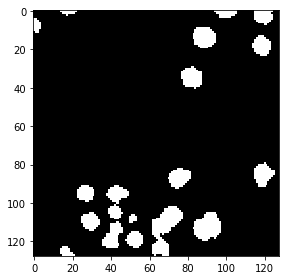

In [43]:
imshow(np.squeeze(preds_train[0]> 0.5))

In [44]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)

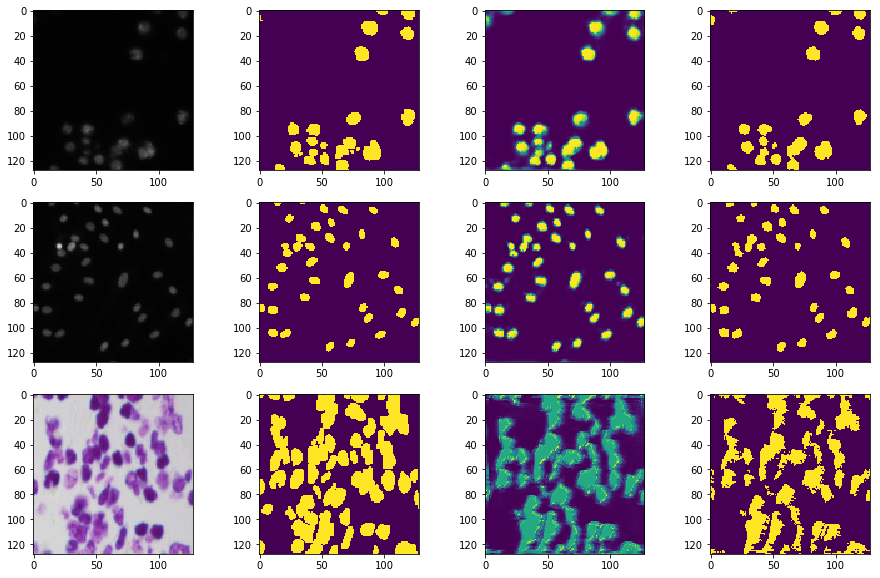

In [45]:
f, axarr = plt.subplots(3,4,figsize=(15.5,10))
for i in range(0,3):
    axarr[i,0].imshow(X_train[i])
    axarr[i,1].imshow(np.squeeze(Y_train[i]))
    axarr[i,2].imshow(np.squeeze(preds_train[i]))
    axarr[i,3].imshow(np.squeeze(preds_train_t[i]))

In [46]:
simple_iou(np.squeeze(preds_train_t[0]),np.squeeze(Y_train[0]))

0.44278283485045511

In [47]:
iou_sum = 0
len1 = 0
for i in range(0,20):
    iou_sum += simple_iou(np.squeeze(preds_train_t[i]),np.squeeze(Y_train[i]))
    len1 += 1
print(iou_sum/ len1, len1)

0.444793575065 20


## Predict on large Unet

In [48]:
model = load_model(large_Unet_model_name)
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

C:\Users\Sharon\Anaconda3\lib\site-packages\keras\engine\topology.py:1242: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


200/200 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s     


### check for some resonable TH, TODO: find best TH

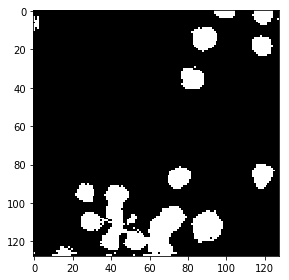

In [57]:
imshow(np.squeeze(preds_train[0]> 0.4))

In [58]:
preds_train_t = (preds_train > 0.4).astype(np.uint8)

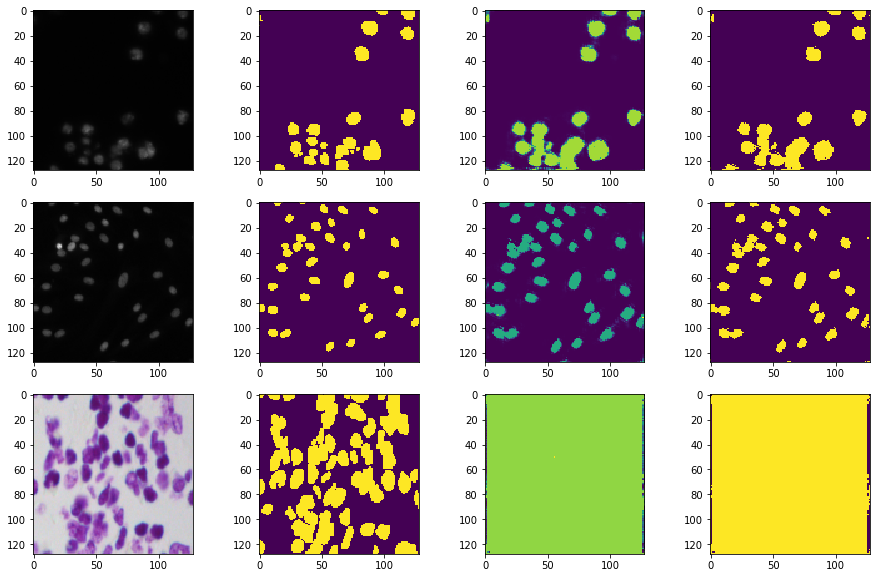

In [59]:
f, axarr = plt.subplots(3,4,figsize=(15.5,10))
for i in range(0,3):
    axarr[i,0].imshow(X_train[i])
    axarr[i,1].imshow(np.squeeze(Y_train[i]))
    axarr[i,2].imshow(np.squeeze(preds_train[i]))
    axarr[i,3].imshow(np.squeeze(preds_train_t[i]))

In [60]:
simple_iou(np.squeeze(preds_train_t[0]),np.squeeze(Y_train[0]))

0.43489583333333331

In [61]:
iou_sum = 0
len1 = 0
for i in range(0,20):
    iou_sum += simple_iou(np.squeeze(preds_train_t[i]),np.squeeze(Y_train[i]))
    len1 += 1
print(iou_sum/ len1, len1)

0.386743905088 20


In [27]:
model = load_model('keras_model-U-net-v1.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

C:\Users\Sharon\Anaconda3\lib\site-packages\keras\engine\topology.py:1242: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


100/100 [==============================] - ETA:  - ETA:  - ETA:  - 2s     


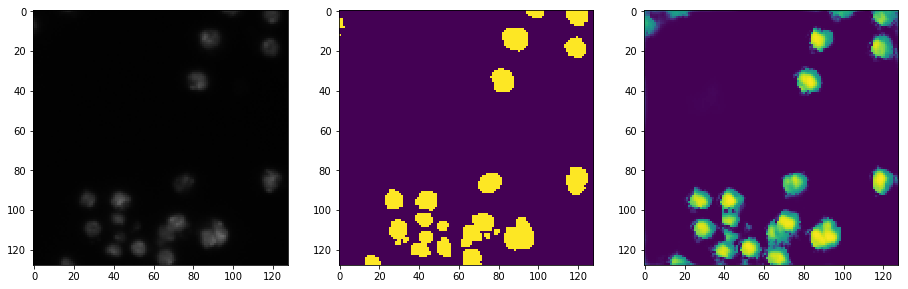

In [34]:
f, axarr = plt.subplots(1,3,figsize=(15.5,10))
axarr[0].imshow(X_train[0])
axarr[1].imshow(np.squeeze(Y_train[0]))
axarr[2].imshow(np.squeeze(preds_train[0]))

In [45]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)

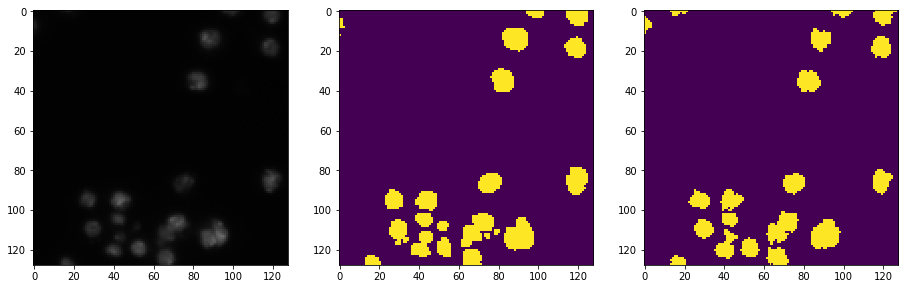

In [46]:
f, axarr = plt.subplots(1,3,figsize=(15.5,10))
axarr[0].imshow(X_train[0])
axarr[1].imshow(np.squeeze(Y_train[0]))
axarr[2].imshow(np.squeeze(preds_train_t[0]))

In [64]:
simple_iou(np.squeeze(preds_train_t[0]),np.squeeze(Y_train[0]))

0.4310850439882698

In [57]:
iou_sum = 0
len1 = 0
for i in range(0,20):
    iou_sum += simple_iou(np.squeeze(preds_train_t[i]),np.squeeze(Y_train[i]))
    len1 += 1
print(iou_sum/ len1, len1)

0.431697894498 20


In [ ]:
# Predict on train, val and test
model = load_model('FCN-v1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [ ]:
# from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
import pydot
plot_model(FCN(), to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
    
#     conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
#     conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
#     conv2 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
#     conv2 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
#     conv3 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
#     conv3 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
#     conv4 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
#     conv4 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
#     drop4 = Dropout(0.5)(conv4)

#     up5 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
#     merge5 = merge([conv3,up5], mode = 'concat', concat_axis = 3)
#     conv5 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge5)
#     conv5 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

#     up6 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
#     merge6 = merge([conv2,up6], mode = 'concat', concat_axis = 3)
#     conv6 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
#     conv6 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

#     up7 = Conv2D(4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
#     merge7 = merge([conv1,up7], mode = 'concat', concat_axis = 3)
#     conv7 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
#     conv7 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    


In [294]:
unet().summary()

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Sharon\Anaconda3\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.p

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_10 (InputLayer)            (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_152 (Conv2D)              (None, 128, 128, 4)   112         input_10[0][0]                   
____________________________________________________________________________________________________
conv2d_153 (Conv2D)              (None, 128, 128, 4)   148         conv2d_152[0][0]                 
____________________________________________________________________________________________________
max_pooling2d_30 (MaxPooling2D)  (None, 64, 64, 4)     0           conv2d_153[0][0]                 
___________________________________________________________________________________________

In [278]:
unet(pretrained_weights = None,input_size = (256,256,1)).summary()

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Sharon\Anaconda3\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.p

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 256, 256, 1)   0                                            
____________________________________________________________________________________________________
conv2d_25 (Conv2D)               (None, 256, 256, 64)  640         input_2[0][0]                    
____________________________________________________________________________________________________
conv2d_26 (Conv2D)               (None, 256, 256, 64)  36928       conv2d_25[0][0]                  
____________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)   (None, 128, 128, 64)  0           conv2d_26[0][0]                  
___________________________________________________________________________________________

C:\Users\Sharon\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


TypeError: peak_local_max() got an unexpected keyword argument 'abels'

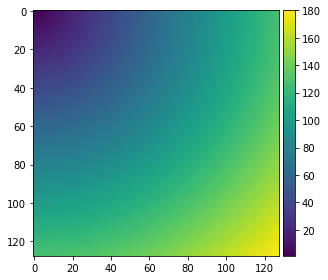

In [247]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max


image = X_train[0][:, :, 0]
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance= ndi.distance_transform_edt(image)
imshow(distance)
local_maxi = peak_local_max(distance, indices=False, abels=image)

print(local_maxi)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()